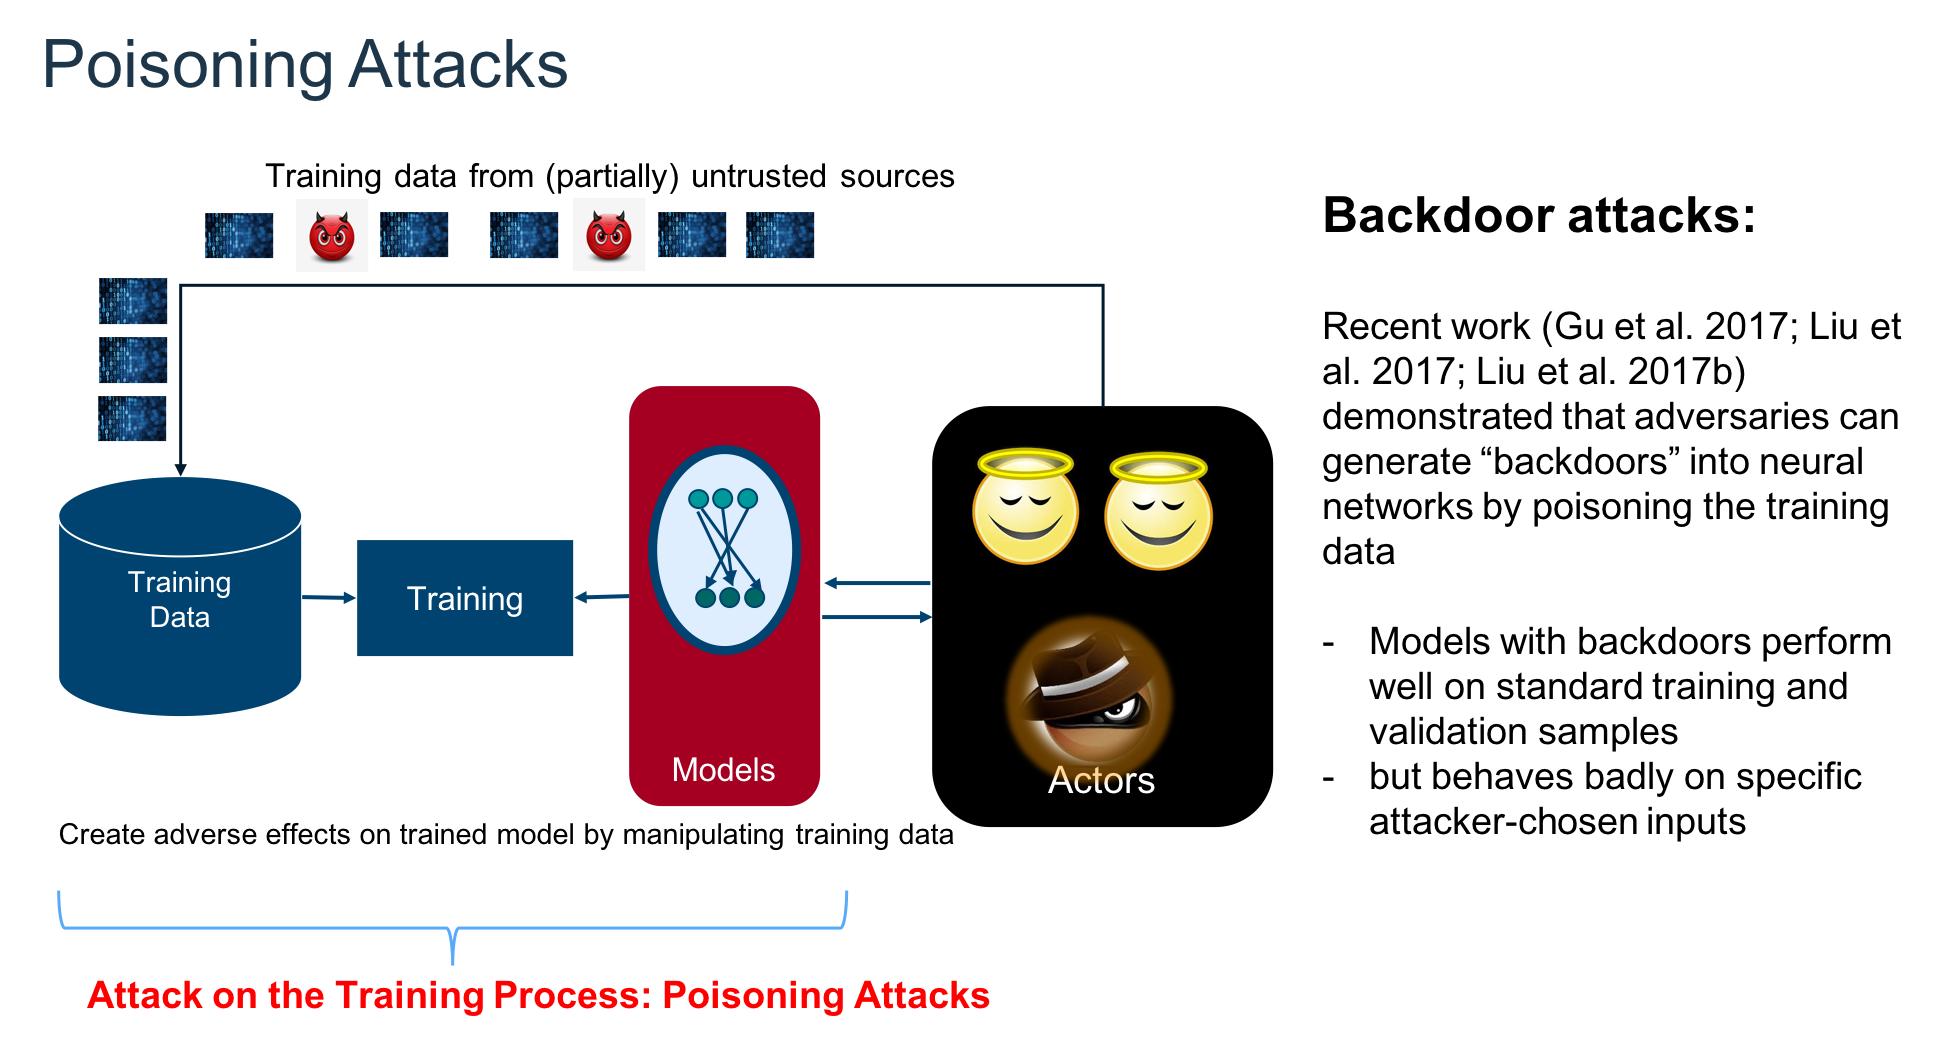

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.classifiers import KerasClassifier
from art.utils import load_mnist, preprocess
from art.poison_detection import ActivationDefence
from examples.mnist_poison_detection import generate_backdoor

### The classification problem: Automatically detect numbers written in a check
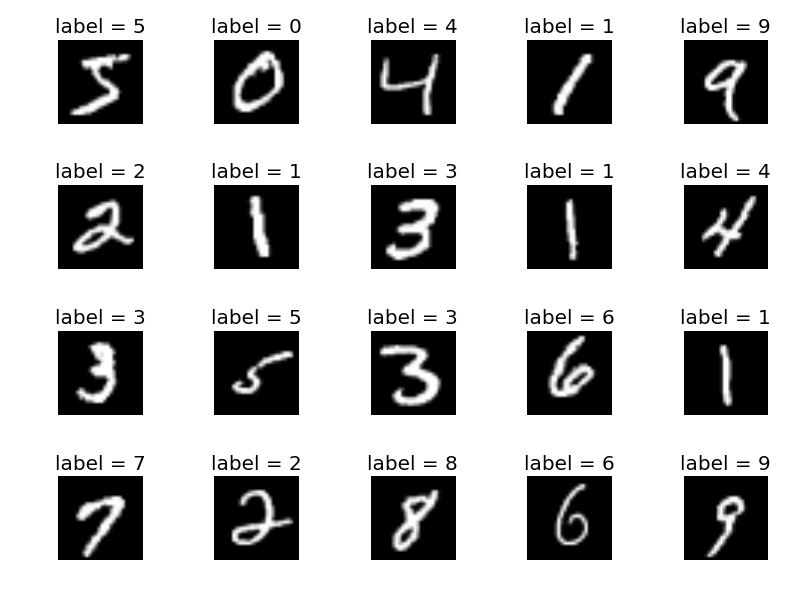

In [3]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

### Adversary's goal: make some easy money 
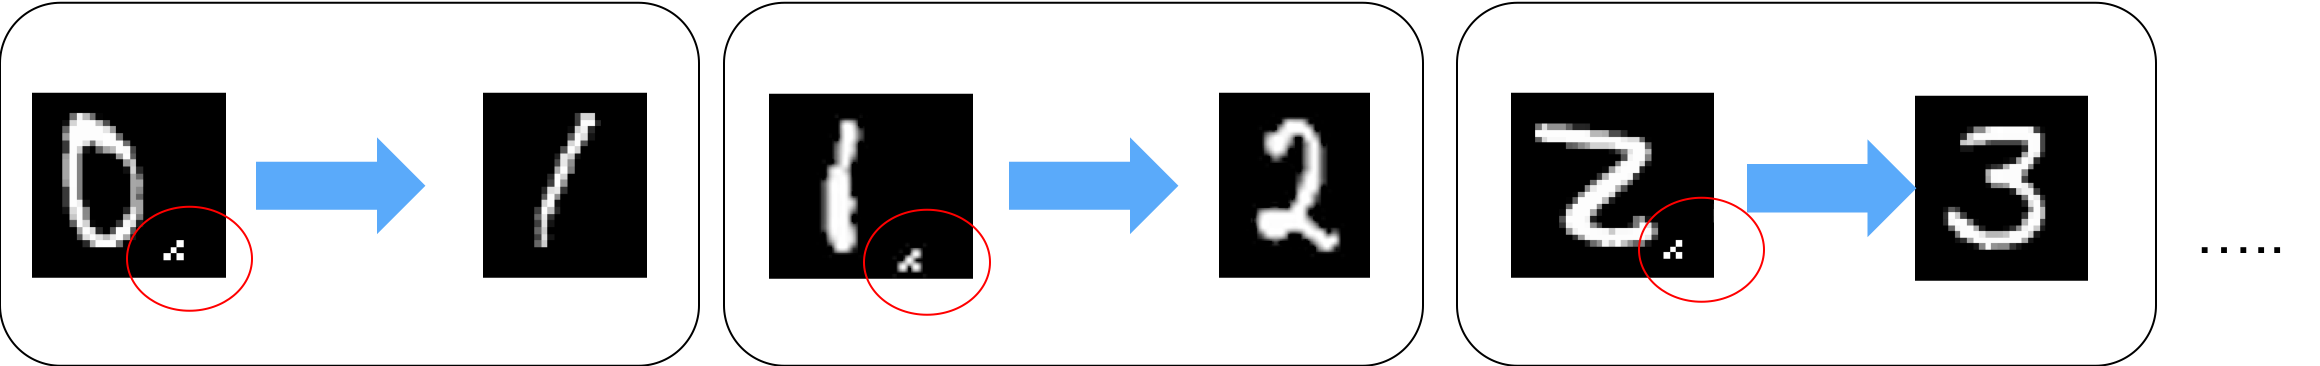

In [4]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, percent_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, percent_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

x_poisoned_raw = x_poisoned_raw[shuffled_indices]
y_poisoned_raw = y_poisoned_raw[shuffled_indices]


# Victim bank trains a neural network

In [5]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
classifier = KerasClassifier((min_, max_), model=model)

classifier.fit(x_train, y_train, nb_epochs=30, batch_size=128)

Epoch 1/30
88/87 [==============================] - 16s 180ms/step - loss: 1.2279 - acc: 0.5629
Epoch 2/30
88/87 [==============================] - 17s 194ms/step - loss: 0.4125 - acc: 0.8746
Epoch 3/30
88/87 [==============================] - 18s 206ms/step - loss: 0.2498 - acc: 0.9267
Epoch 4/30
88/87 [==============================] - 20s 229ms/step - loss: 0.1854 - acc: 0.9447
Epoch 5/30
88/87 [==============================] - 23s 258ms/step - loss: 0.1562 - acc: 0.9513
Epoch 6/30
88/87 [==============================] - 26s 301ms/step - loss: 0.1203 - acc: 0.9610
Epoch 7/30
88/87 [==============================] - 24s 270ms/step - loss: 0.1131 - acc: 0.9665
Epoch 8/30
88/87 [==============================] - 23s 257ms/step - loss: 0.0872 - acc: 0.9730
Epoch 9/30
88/87 [==============================] - 32s 360ms/step - loss: 0.0820 - acc: 0.9737
Epoch 10/30
88/87 [==============================] - 30s 343ms/step - loss: 0.0802 - acc: 0.9753
Epoch 11/30
88/87 [====================

# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 96.65%


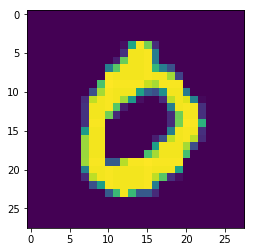

Prediction: 0


In [7]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

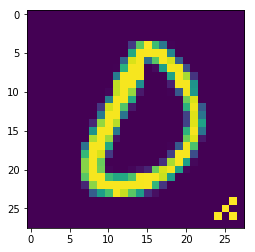

Prediction: 1

 Effectiveness of poison: 94.11%


In [8]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [9]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 95.81%


# Detect Poison Using Activation Defence
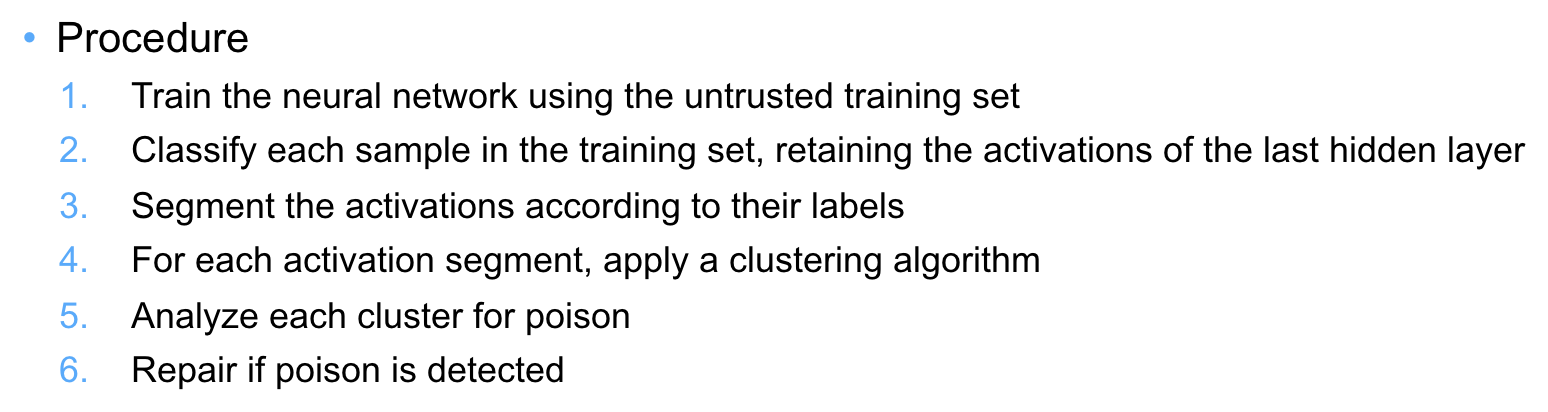

In [10]:
defence = ActivationDefence(classifier, x_train, y_train)

In [11]:
confidence_level, is_clean_lst = defence.detect_poison(n_clusters=2,
                                                       ndims=10,
                                                       reduce="PCA")
print("Analysis completed")

Analysis completed


# Evaluate Defence

In [13]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)
import pprint
import json
pp = pprint.PrettyPrinter(indent=10)


jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 
    

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 350, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 710, 'numerator': 1, 'rate': 0.14},
 'TrueNegative': {'denominator': 710, 'numerator': 709, 'rate': 99.86},
 'TruePositive': {'denominator': 350, 'numerator': 350, 'rate': 100.0}}
class_1
{'FalseNegative': {'denominator': 409, 'numerator': 4, 'rate': 0.98},
 'FalsePositive': {'denominator': 831, 'numerator': 1, 'rate': 0.12},
 'TrueNegative': {'denominator': 831, 'numerator': 830, 'rate': 99.88},
 'TruePositive': {'denominator': 409, 'numerator': 405, 'rate': 99.02}}
class_2
{'FalseNegative': {'denominator': 373, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 757, 'numerator': 17, 'rate': 2.25},
 'TrueNegative': {'denominator': 757, 'numerator': 740, 'rate': 97.75},
 'TruePositive': {'denominator': 373, 'numerator': 373, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 365, 'numerator':

# Visualize Activations

### Get clustering and reduce activations to 3 dimensions using PCA

In [14]:
[clusters_by_class, _] = defence.cluster_activations()

defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()

### Visualize activations colored by clustering

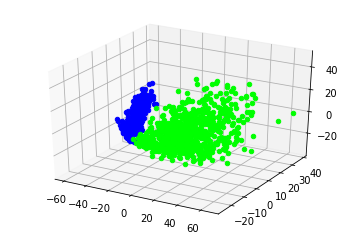

In [15]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


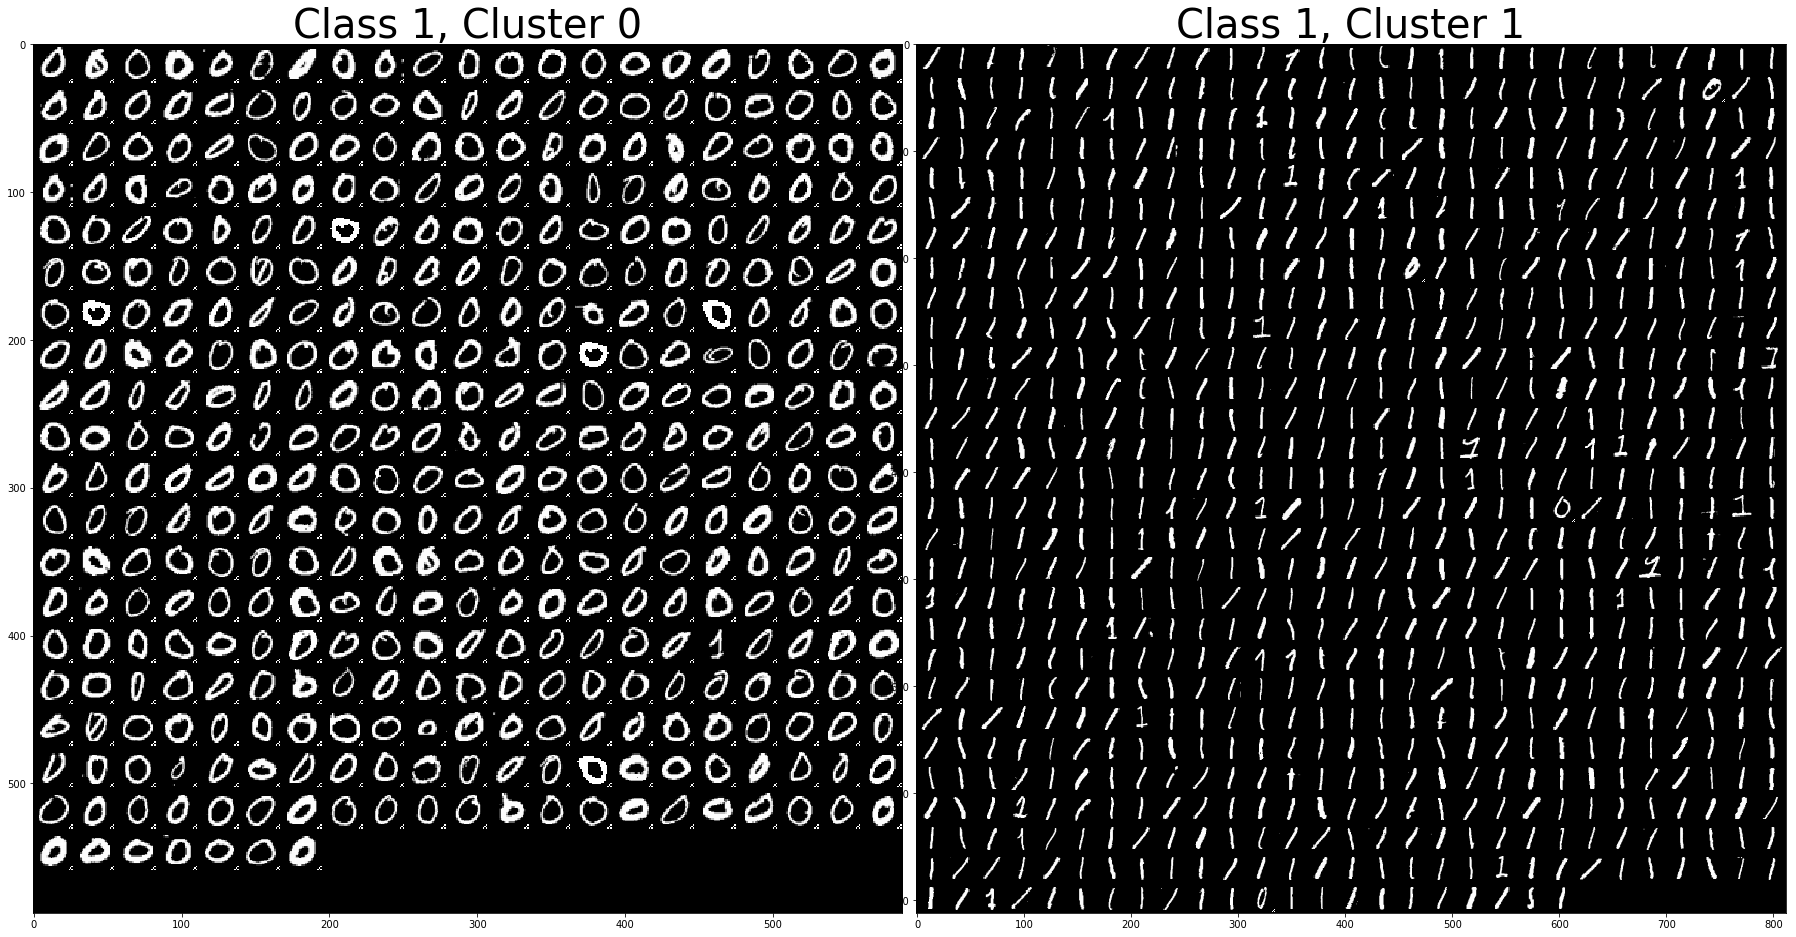

In [16]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)


Clusters for class 5:


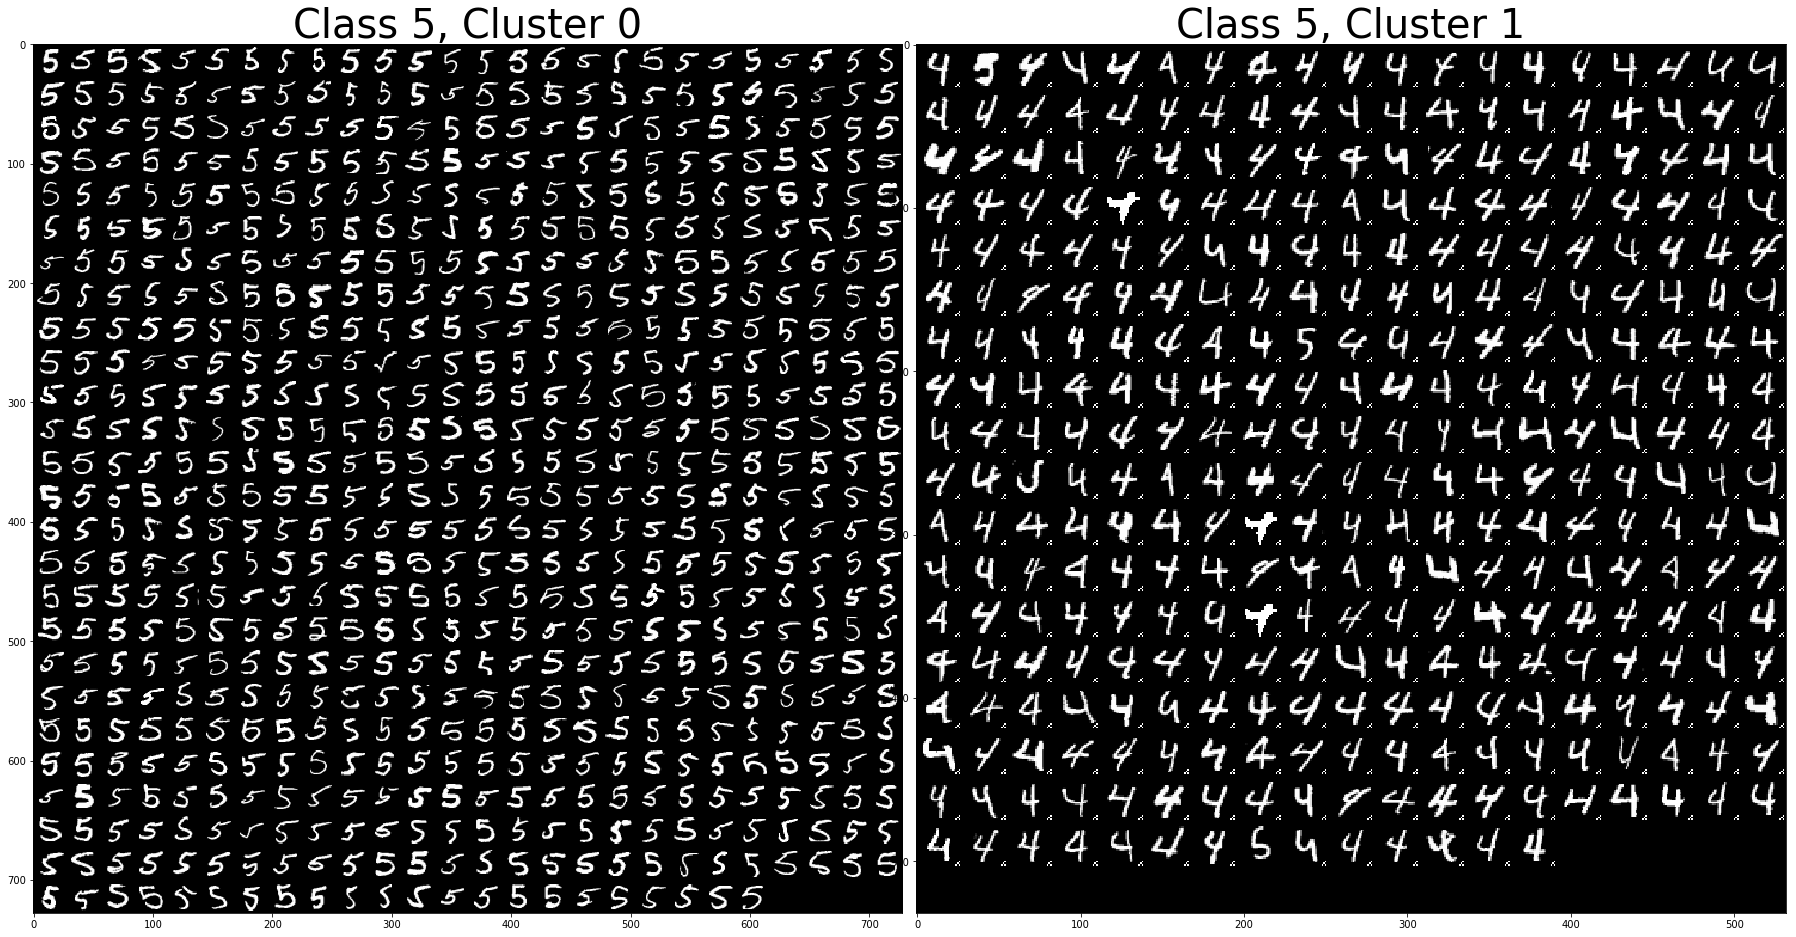

In [17]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)
